In [5]:
import pandas as pd
pd.Series
import math
import csv
from datetime import datetime
import numpy as np
import scipy as sc
import statsmodels
import sklearn
from sklearn import preprocessing
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 17
rcParams.update({'font.size': 22})
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from matplotlib import pyplot

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

### Load file, print info and select columns

In [6]:
#function to load files
def load_file(filepath):
    df = pd.read_csv(filepath, sep='\t', index_col=0, parse_dates=True)
    df = df.sort_index()
    #we can check that this 2 columns are equal, so we can drop one
    #any(df['SALE_AMOUNT_BEFORE_CANCELLATIONS'] != df['SALE_AMOUNT_AFTER_CANCELLATIONS'])
    df = df.drop(['SALE_AMOUNT_AFTER_CANCELLATIONS'], axis=1)
#...
    return df.astype('float32')

#function to create a new df with selected columns
def create_small_df(df, columns):
    small_df = df.copy()
    small_df = small_df[columns]
    return small_df

#function to print inf about Data
def print_info_df(df, print_columns = False):
    #Count period
    d1 = df.index[0]
    d2 = df.index[-1]
    delta = d2 - d1
    print('Number of days is ' + str(delta.days) + ' from ' + str(d1) + ' to '+ str(d2))
    print('The shape of the data: %d*%d' %(df.shape[0],df.shape[1]))
    print('Check for Nan values: %s'%(df.isnull().values.any()))
    if (print_columns == True):
        print(list(df.columns))
    else:
        print('Number of columns: %d'%(df.shape[1]))

In [7]:
full_df = load_file('...')

df = full_df.head(1642)
df_test = full_df.tail(154)

print_info_df(df, False)
print('--------------------')
print_info_df(df_test, False)

feature = 'SALE_AMOUNT'

Number of days is 1641 from 2014-01-01 00:00:00 to 2018-06-30 00:00:00
The shape of the data: 1642*23
Check for Nan values: False
Number of columns: 23
--------------------
Number of days is 153 from 2018-07-01 00:00:00 to 2018-12-01 00:00:00
The shape of the data: 154*23
Check for Nan values: False
Number of columns: 23


## Error Metrics

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_square_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def relative_rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = root_mean_square_error(y_true, y_pred)
    return (rmse / np.mean(y_true))*100

#def f_smape(A, F):
#    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def f_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 0.1
    summ = np.maximum(np.abs(y_true) + np.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = np.abs(y_pred - y_true) / summ * 2.0
    return np.mean(smape)

## SARIMA

In [14]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    plt.subplot(2, 1, 1)
    plt.plot(predicted, label='yhat', linestyle='--', lw=2)
    plt.plot(actual, label='y', lw=2)
    plt.title('SARIMA: Observed and Predicted Values')
    plt.legend(prop={'size': 15})
    plt.grid(True)
    plt.show()
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def run_sarima(train ,test, cfg):
    predictions = list()
    #train, test = train_test_split(data, n_test)
    history = train.tolist()
    # step over each time-step in the test set
    for i in range(len(test)):
        yhat = sarima_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    rmse = root_mean_square_error(test, predictions)
    rel_rmse = relative_rmse(test, predictions)   
    results = [error, mape, rmse, rel_rmse]
    return results, test, predictions

def show_results(results, test, predictions):
    
    error=results[0]
    mape=results[1]
    rmse=results[2]
    rel_rmse=results[3]
    
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % (rmse))
    print('Test Relative RMSE: %.3f' % (rel_rmse))
    print('Test MAPE: %.3f' % (mape))

    x1=30
    x2=60

    plt.subplot(2, 1, 1)
    plt.plot(predictions, label='yhat', linestyle='--', lw=2)
    plt.plot(test, label='y', lw=2)
    xposition = [x1,x2]
    for xc in xposition:
        plt.axvline(x=xc, color='k', linestyle='--')
    plt.title('SARIMA: Observed and Predicted Values')
    plt.ylabel(feature)
    plt.legend(prop={'size': 22})
    plt.grid(True)
    plt.show() 
    
    plt.subplot(2, 1, 1)
    plt.plot(predictions[x1:x2], label='yhat', linestyle='--', lw=2)
    plt.plot(test[x1:x2], label='y', lw=2)
    plt.title('SARIMA: Observed and Predicted Values')
    plt.ylabel(feature)
    plt.legend(prop={'size': 22})
    plt.grid(True)
    plt.show()
    


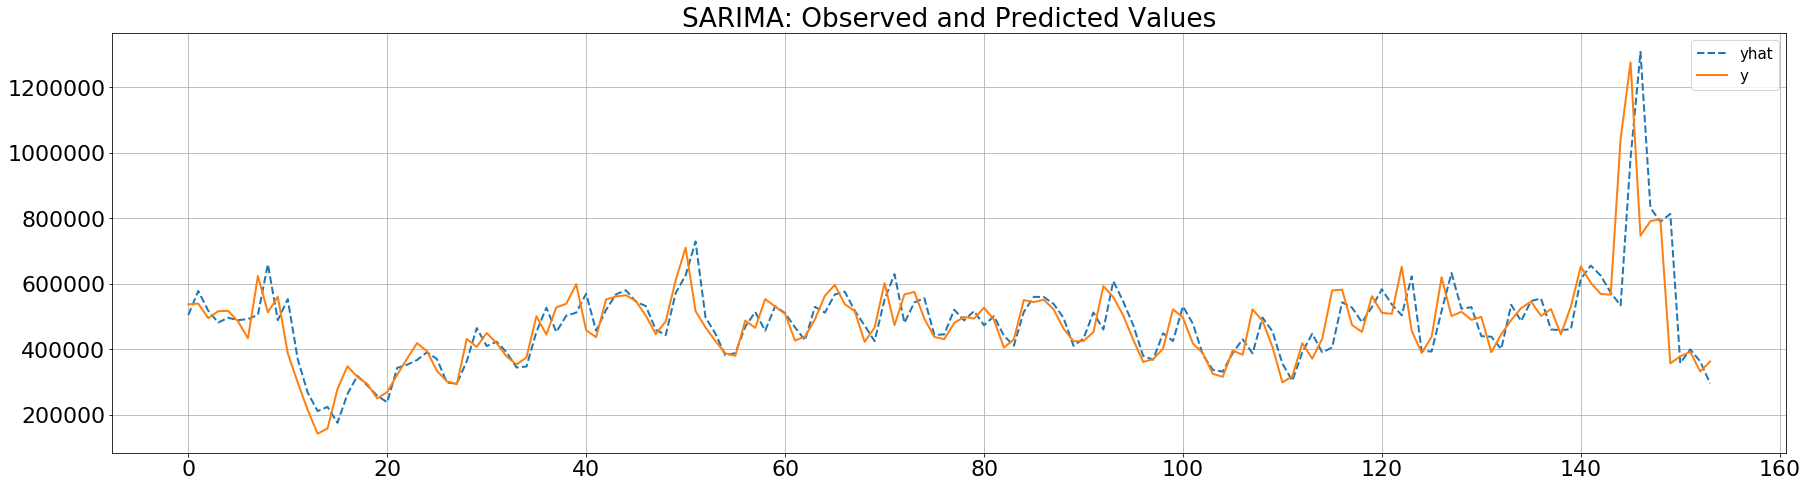

In [10]:
train = df[feature][1000:].values
test = df_test[feature][:].values

history = train.tolist()
#cfg = [(1, 1, 1), (1, 1, 2, 7), 't']
cfg = [(0, 1, 0), (1, 0, 1, 7), 'c']

import warnings
warnings.filterwarnings("ignore")
results, test, predictions = run_sarima(train, test, cfg)

# for i in list_cfg:
#     print('Model: ' + str(i))
#     scores = [score_model(data, n_test, i)]
#     #print('Result: %.3f' %(scores[1]))

Test MSE: 95615.586
Test RMSE: 95615.586
Test Relative RMSE: 20.141
Test MAPE: 11.505


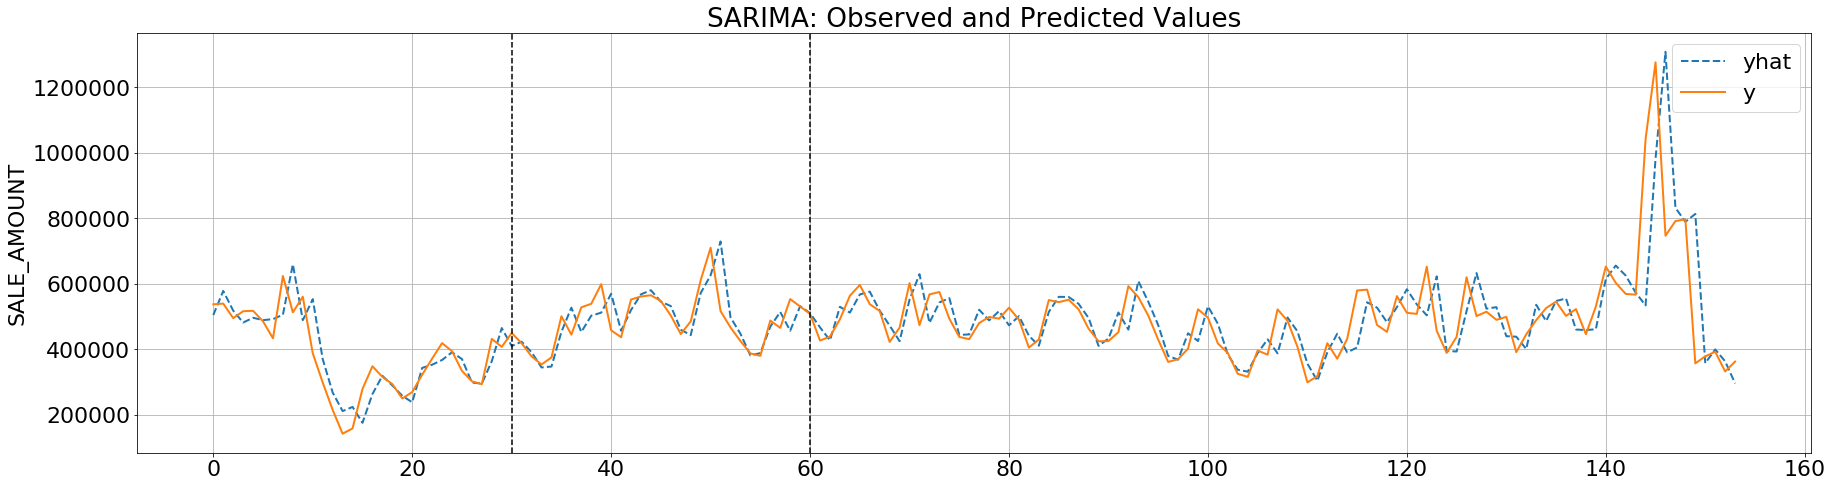

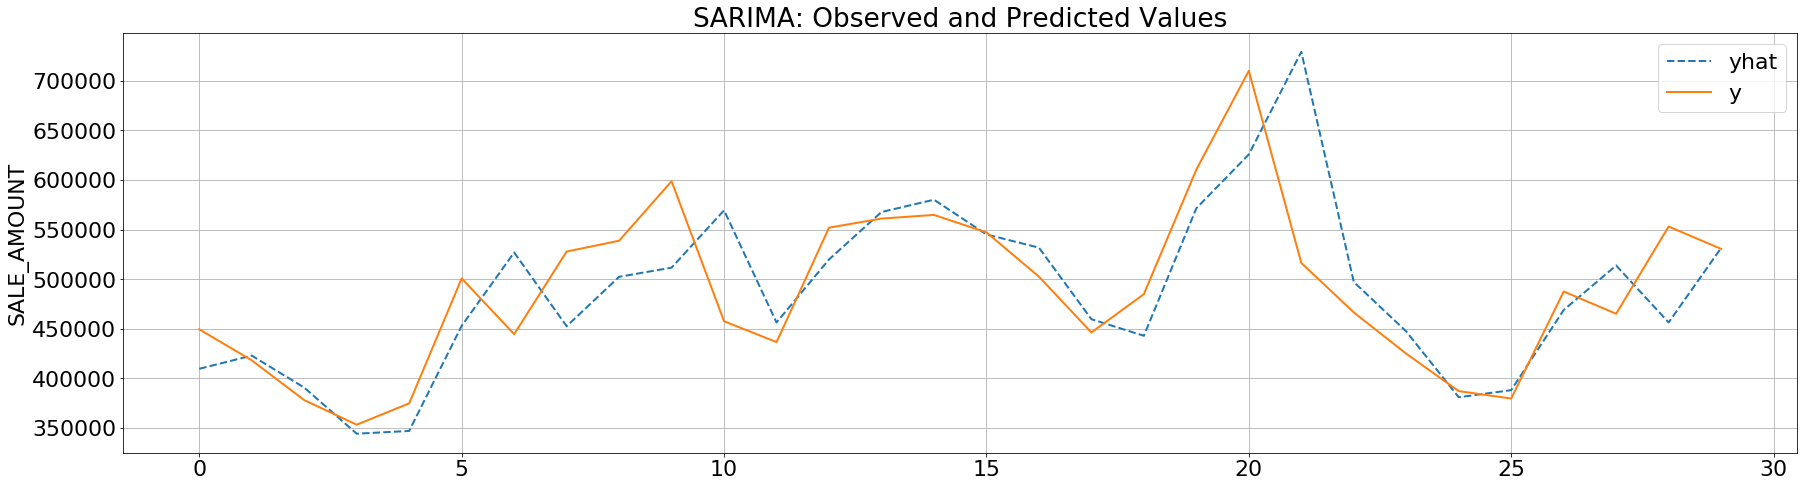

In [15]:
show_results(results, test, predictions)

In [ ]:
cfg2 = [(0, 1, 0), (1, 0, 1, 7), 'c']
results2, test2, predictions2 = run_sarima(train, test, cfg2)

In [ ]:
show_results(results2, test2, predictions2)